In [1]:
!sudo apt-get install git-lfs
!git-lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,056 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155222 files and directories c

In [2]:
!git lfs clone https://github.com/GiorgiaAuroraAdorni/gansformer-reproducibility-challenge.git

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'gansformer-reproducibility-challenge'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 306 (delta 168), reused 222 (delta 90), pack-reused 0
Receiving objects: 100% (306/306), 1.96 MiB | 11.88 MiB/s, done.
Resolving deltas: 100% (168/168), done.
Git LFS: (1 of 1 files) 307.61 MB / 307.61 MB


In [3]:
%cd /content/gansformer-reproducibility-challenge/src

/content/gansformer-reproducibility-challenge/src


In [4]:
!pip install tensorflow-gpu==1.15.3

     |████████████████████████████████| 411.0 MB 40 kB/s 
     |████████████████████████████████| 503 kB 28.9 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 3.8 MB 30.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=93bb169170d94dcea6e2ba33037b1418bee6e4fe7025912e1d65849154e4f28c
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [5]:
%tensorflow_version 1.x
import tensorflow as tf

%matplotlib inline 
from matplotlib import pyplot as plt

# Download the model of choice
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

# Useful utility functions...
import cv2
import pretrained_networks

# network_pkl = "/content/drive/MyDrive/gansformer-reproducibility-challenge/network-snapshot-000300.pkl"
# network_type = "ganformer"

network_pkl = "trained_network/Stylegan2_300kimg.pkl"
network_type = "stylegan2"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

TensorFlow 1.x selected.
Loading networks from "trained_network/Stylegan2_300kimg.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [6]:
# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi, network_type):
    Gs_kwargs = dnnlib.EasyDict()
    if network_type == "stylegan2":
      Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]

        if network_type == 'ganformer':
          res_images = np.transpose((images[0][0, :, :, :]), (1, 2, 0))

        elif network_type == 'stylegan2': 
          res_images = images[0]

        else:
          raise ValueError('Invalid network_type')

        res_images = (res_images - np.min(res_images))/np.ptp(res_images)
        imgs.append(res_images)

    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi, network_type):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi, network_type)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


[6319140 1318392 9424831]


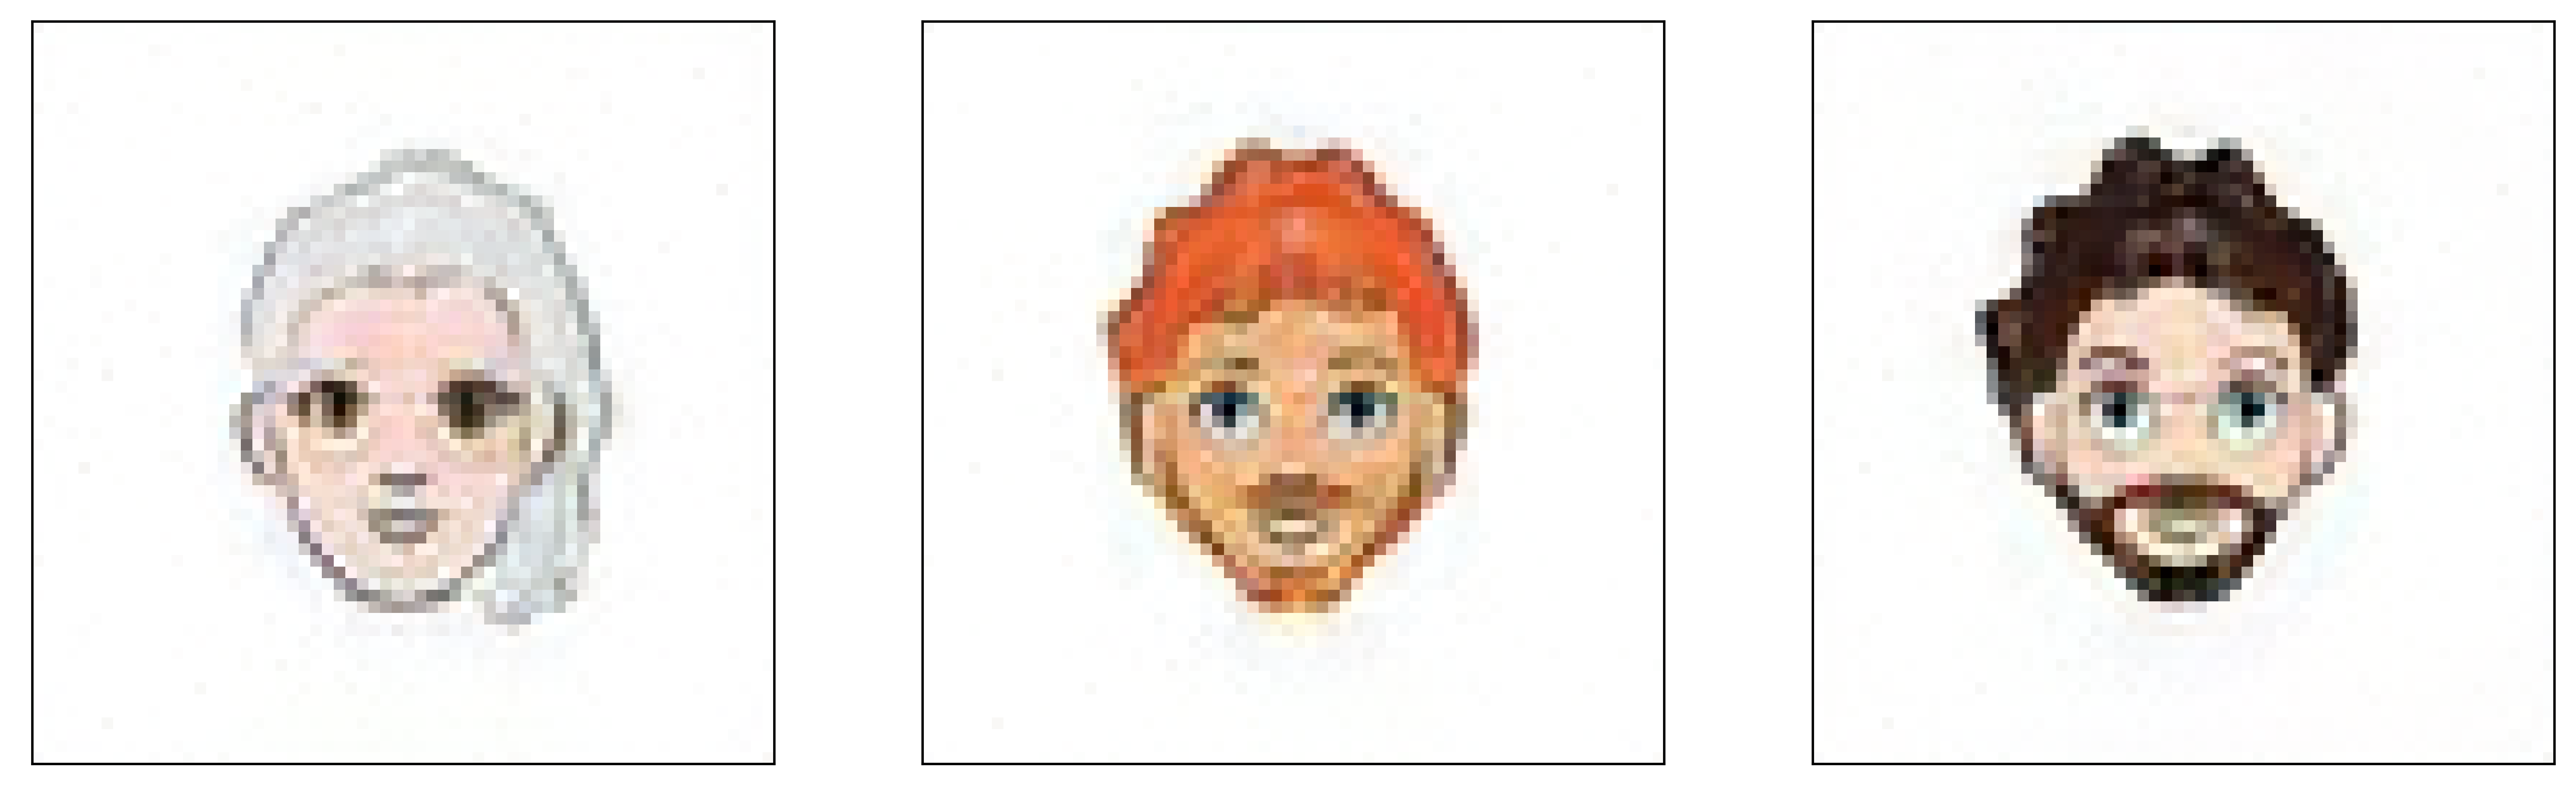

In [7]:
# generate some random seeds
seeds = np.random.randint(10000000, size=3)
print(seeds)

# show the seeds
out = generate_images_from_seeds(seeds, 0.7, network_type)

fig, ax = plt.subplots(1, len(seeds), figsize=(15, 15*len(seeds)), dpi=600)

for l_idx, l in enumerate(out):
  ax[l_idx].get_xaxis().set_visible(False)
  ax[l_idx].get_yaxis().set_visible(False)
  ax[l_idx].imshow(l)

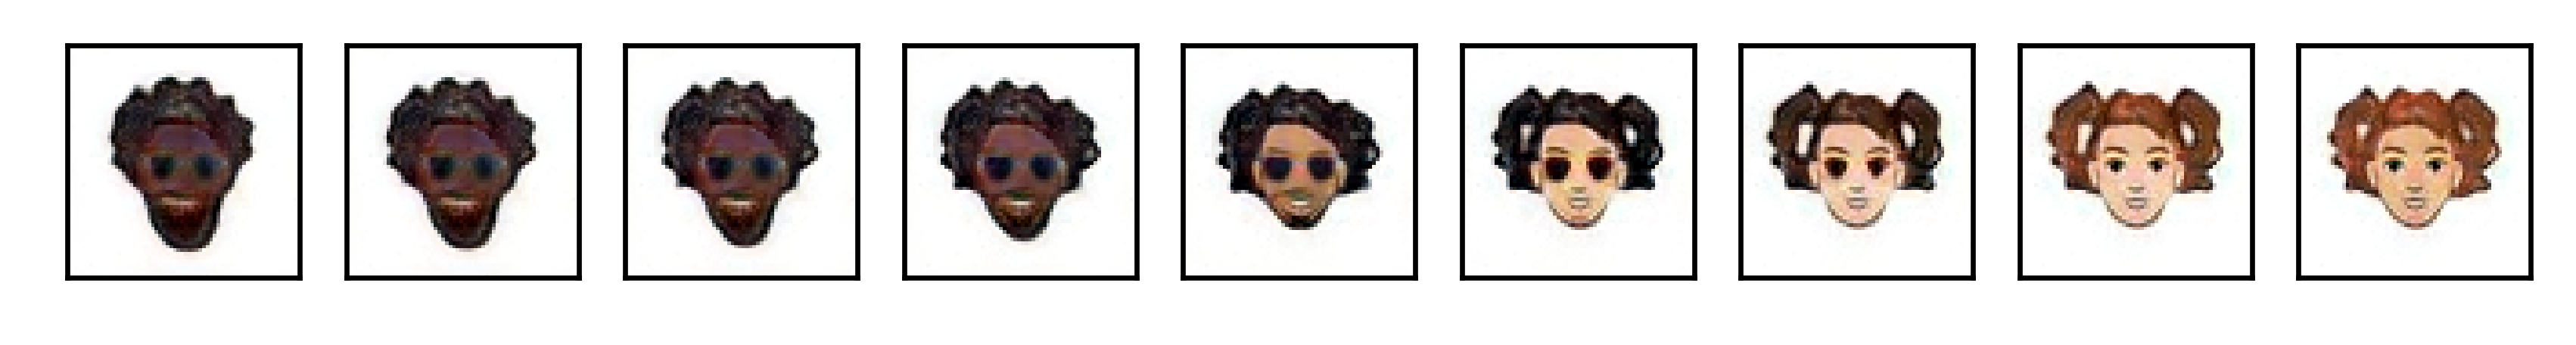

In [8]:
# Simple (Z) interpolation
zs = generate_zs_from_seeds([5015289, 9148088])

latent1 = zs[0]
latent2 = zs[1]

number_of_steps = 9

imgs = generate_images(interpolate([latent1,latent2],number_of_steps), 1.0, network_type)

fig, ax = plt.subplots(1, len(imgs), figsize=(7,7*len(imgs)), dpi=600)
for l_idx, l in enumerate(imgs):
  ax[l_idx].get_xaxis().set_visible(False)
  ax[l_idx].get_yaxis().set_visible(False)
  ax[l_idx].imshow(l)

In [9]:
# generating a MP4 movie
from skimage import img_as_ubyte


zs = generate_zs_from_seeds([421645,6149575,3487643,3766864 ,3857159,5360657,3720613])

number_of_steps = 100
imgs = generate_images(interpolate(zs,number_of_steps), 1.0, network_type)
# Example of reading a generated set of images, and storing as MP4.
%mkdir out
movieName = 'out/mov.mp4'
with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(img_as_ubyte(image)))

# Projecting images onto the generatable manifold

#StyleGAN2 comes with a projector that finds the closest generatable image based on any input image. This allows you to get a feeling for the diversity of the portrait manifold.

In [10]:
!mkdir projection
!mkdir projection/imgs
!mkdir projection/out

# Now upload a single image to 'stylegan2/projection/imgs' (use the Files side panel). Image should be color PNG, with a size of 6ax64.

In [14]:
# Convert uploaded images to TFRecords
import dataset_tool
from sys import exit
dataset_tool.create_from_images("./projection/out/", "./projection/imgs/", True)

# Run the projector
import run_projector
import projector
import training.dataset
import training.misc
import os 

def project_real_images(dataset_name, data_dir, num_images, num_snapshots):
    proj = projector.Projector()
    proj.set_network(Gs)

    print('Loading images from "%s"...' % dataset_name)
    dataset_obj = training.dataset.load_dataset(data_dir=data_dir, 
                                                tfrecord_dir=dataset_name, 
                                                max_label_size=0, 
                                                verbose=True, 
                                                repeat=False, 
                                                shuffle_mb=0)
    assert dataset_obj.shape == Gs.output_shape[1:]

    for image_idx in range(num_images):
        print('Projecting image %d/%d ...' % (image_idx, num_images))
        images, _labels = dataset_obj.get_minibatch_np(1)
        images = training.misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
        run_projector.project_image(proj, 
                                    targets=images, 
                                    png_prefix=dnnlib.make_run_dir_path('projection/out/image%04d-' % image_idx), 
                                    num_snapshots=num_snapshots)

project_real_images("records","./projection",1,100)

Loading images from "./projection/imgs/"
Creating dataset "./projection/out/"
Added 1 images.
Loading images from "records"...
Streaming data using training.dataset.TFRecordDataset...


AssertionError: ignored

In [ ]:
# Create video 

import glob

imgs = sorted(glob.glob("projection/out/*step*.png"))

target_imgs = sorted(glob.glob("projection/out/*target*.png"))
assert len(target_imgs) == 1, "More than one target found?"
target_img = imageio.imread(target_imgs[0])

movieName = "projection/movie.mp4"
with imageio.get_writer(movieName, mode='I') as writer:
    for filename in log_progress(imgs, name = "Creating animation"):
        image = imageio.imread(filename)

        # Concatenate images with original target image
        w,h = image.shape[0:2]
        canvas = PIL.Image.new('RGBA', (w*2,h), 'white')
        canvas.paste(Image.fromarray(target_img), (0, 0))
        canvas.paste(Image.fromarray(image), (w, 0))

        writer.append_data(np.array(canvas))  

In [ ]:
# Now you can download the video (find it in the Files side panel under 'stylegan2/projection')

# To cleanup
!rm projection/out/*.*
!rm projection/records/*.*
!rm projection/imgs/*.*